In [2]:
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
from signals import *
from plots import *
from samplers import *
from pylab import rcParams
import itertools
from matplotlib import cm
rcParams['figure.figsize'] = 5, 2.5
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
from mpl_toolkits.mplot3d import Axes3D

# Sampling at unknown locations: all the figures

This notebook generates all figures used in the paper
*Sampling at unknown locations: Uniqueness andreconstruction under constraints*, by Golnoosh Elhami et. al. 

## Illustrative figures
This part of the notebook generates illustrative figures of the paper and runs quite fast

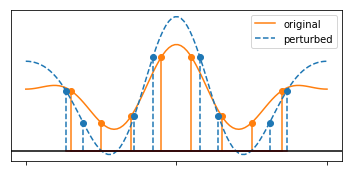

In [5]:
signal = SignalExp([-0.3, 0.5, -0.1, 1])
change = 0.5*np.array([0, 1, 0, 0])
t = np.linspace(0, 2*np.pi, 100)
sample_positions = np.multiply([0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7], np.pi)

new_signal = SignalExp(signal.parameters + change)
sample_values = signal.get_samples(sample_positions)

new_positions = []
for s in sample_positions:
    p = signal.path(s, change, n=10)
    new_positions.append(p[-1])

fig, ax = plt.subplots()
ax.plot(t, signal.get_samples(t), "C1", label="original")
ax.stem(sample_positions, sample_values,  linefmt="C1", markerfmt="C1o")
ax.plot(t, new_signal.get_samples(t), "--C0", label="perturbed")
ax.stem(new_positions, sample_values, linefmt="--C0")
ax.axhline(0, c='k')
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.legend()
plt.tight_layout()
fig.savefig('shifting.pdf')
plt.show()

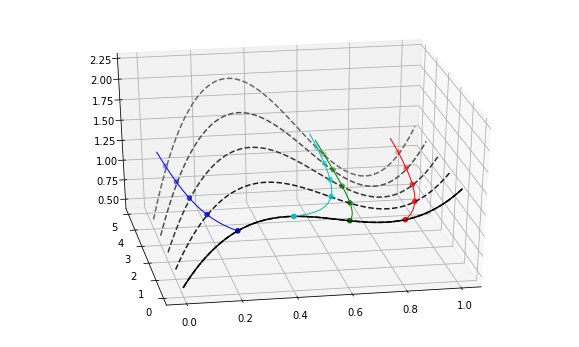

In [6]:
start_params = np.array([6, -10, 5, 0.5])
changes = np.array([3, -5, 2, 0])
polynomial = SignalPolynomial(start_params)

alpha = np.linspace(0, 5)
colors = itertools.cycle(["b", "c", "g", "r"])
grays = itertools.cycle(['0.0','0.1','0.2','0.3','0.4'])
sample_positions = [0.2, 0.4, 0.6, 0.8]
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111, projection='3d')
t = np.linspace(0, 1, 100)
z = polynomial.get_samples(t)
ax.plot(t, np.zeros_like(t), z, 'k')

sample_values = polynomial.get_samples(sample_positions)

for i in range(5):
    pol = SignalPolynomial(start_params+i*changes)
    z = pol.get_samples(t)
    ax.plot(t, np.ones_like(t)*i, z, next(grays), linestyle="--")

for s, v in zip(sample_positions, sample_values):
    color = next(colors)
    path = np.real(polynomial.path(s, 5*changes))
    ax.plot(path, alpha, v*np.ones_like(alpha), lw=1, color=color)
    ax.scatter(path[0::10], alpha[0::10], v*np.ones(5), lw=1, color=color)

ax.view_init(30, -100)
plt.savefig("paths.pdf")
plt.show()

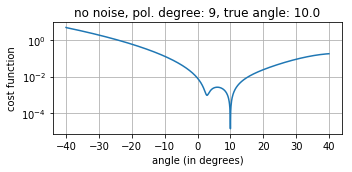

In [12]:
true_angle = np.pi/18

p = np.array([1.000000000000000000e+00,-2.825421682312351468e+00,-2.022133420929154990e-01,
              -1.483193386636804334e+00,-2.063111012904942587e+00,5.638963672080870015e-01,
              -3.154727063937948994e+00,1.396869864645395032e-01,-2.631363077020359764e+00,
              3.202233789725539292e+00])       
polynomial = SecondSurfacePolynomial(p)
t = np.linspace(-1,1, 100)
sampler = SurfaceSampler(polynomial, 2*len(p), [true_angle, 1, 1], interval_length=2, sigma=0.0, beg=-1)

err1 = []
values = sampler.sample_values + 1e-2*np.random.randn(len(sampler.sample_values))
angles = np.linspace(-np.pi/4.5, np.pi/4.5, 900)
for a in angles:
    err1.append(known_error(sampler.sample_positions, len(p), [a, 1, 1], values))

err = []
values = sampler.sample_values
angles = np.linspace(-np.pi/4.5, np.pi/4.5, 900)
for a in angles:
    err.append(known_error(sampler.sample_positions, len(p), [a, 1, 1], values))
    
fig = plt.figure()
plt.semilogy(np.degrees(angles), err)
plt.xlabel("angle (in degrees)")
plt.ylabel("cost function")
plt.title("no noise, pol. degree: 9, true angle: "+str(np.degrees(true_angle)))
plt.grid()
plt.tight_layout()
plt.show()
fig.savefig("non_convex.pdf")

## Experiments results
This part of notebook plots resutls from quite extensive experiments, 
and therefore cannot be run without runing the experiments first.

To generate experiment results, run in a python console:

`exec(open("surface-tests.py").read())`

Note that running experiments take time. On four Intel i7 processors it takes a night. TODO?

In [34]:
all_errors = np.zeros((4, 11, 100*13))
max_degree = 10

for n in range(3, max_degree):
    for nl in [0, 1, 2, 3]:
        code1 = "{}_1_{}".format(n, nl)
        code2 = "{}_1_{:.2f}".format(n, nl)
        try:
            errors = np.load('results/errors_' + code1 + '.npy')
        except:
            errors = np.load('results/errors_' + code2 + '.npy') #TODO
        errors = errors.flatten()
        all_errors[nl,n,:] = errors

all_errors = np.degrees(all_errors)
if np.isnan(all_errors).any():
    print("Number of NaNs: {}".format(np.count_nonzero(np.isnan(all_errors))))
all_errors[np.isnan(all_errors)]=20

Number of NaNs: 1


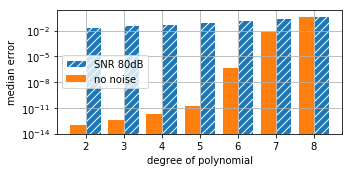

In [32]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ind = np.arange(2,max_degree-1)
width = 0.4
rects1 = ax.bar(ind+(width/2), np.median(all_errors[3,3:max_degree,:],1), width, bottom=1e-14, color="C0", edgecolor='w', hatch="///")
rects2 = ax.bar(ind-(width/2), np.median(all_errors[0,3:max_degree,:],1), width, bottom=1e-14, color="C1")
plt.xlabel("degree of polynomial")
plt.ylabel("median error")
plt.legend(["SNR 80dB", "no noise"], loc=6)
plt.grid()
plt.tight_layout()
plt.show()
fig.savefig('degree_bar.pdf')

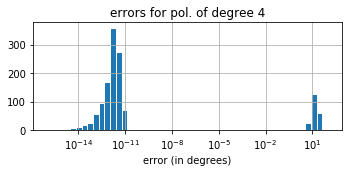

In [35]:
fig = plt.figure()
plt.hist(all_errors[0,5,:],  bins=np.logspace(-16, 2, 50), edgecolor='w')
plt.xscale('log', nonposx='clip')
plt.title("errors for pol. of degree 4")
plt.xlabel("error (in degrees)")
plt.grid()
plt.tight_layout()
plt.show()
fig.savefig('two_modes.pdf')

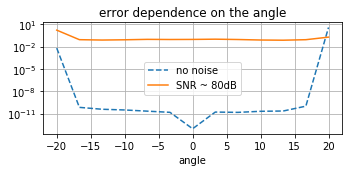

In [20]:
a = np.linspace(-20,20, 13)

fig2, ax2 = plt.subplots()
angle_err = all_errors[0,3:10,:]
angle_err_med = np.median(angle_err.reshape((700, 13)),0)
ax2.semilogy(a, angle_err_med, 'C0--', label="no noise")
ax2.set_xlabel('angle')
plt.title("error dependence on the angle")

ax3 = ax2
angle_err = all_errors[3,3:10,:]
angle_err_med = np.median(angle_err.reshape((700, 13)),0)
ax3.semilogy(a, angle_err_med, 'C1-', label='SNR ~ 80dB')
ax2.grid()
plt.legend()
plt.tight_layout()
fig2.savefig("angle.pdf")
    
plt.show()

In [38]:
results = np.empty((2, 4, 5, 5))
all_errors = np.empty((4, 5, 5, 100*13))
all_nsr = np.empty((4, 5, 5, 100*13))

for (overs, idx) in zip([1, 2, 4, 8], range(4)):
    for n in range(4,5):
        for nl in range(5):
            code = "{}_{}_{}".format(n, overs, nl)
            nsr = np.load('results/nsr_' + code + '.npy')
            errors = np.load('results/errors_' + code + '.npy')
            errors[np.isnan(errors)] = 1
            results[0, idx, nl, n] = np.degrees(np.percentile(errors, q=50))
            results[1, idx, nl, n] = np.degrees(np.mean(errors.flatten()))
            all_nsr[idx, nl, n, :] = nsr.flatten()
            all_errors[idx, nl, n,:] = errors.flatten()

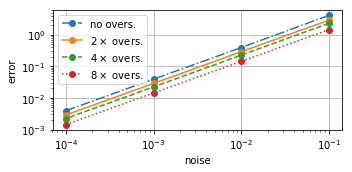

In [39]:
nse = 10.0**(-np.array(range(1, 5)))
fig = plt.figure()
styles = ['-.o', '-o', '--o', ':o']
for idx in range(4):
    plt.loglog(nse, results[0, idx, 1:, 4].T, styles[idx])
plt.xlabel("noise")
plt.ylabel("error")
plt.legend([r"no overs.", r"$2\times $ overs.", r"$4\times $ overs.", r"$8\times $ overs."], loc=2)
plt.grid()
plt.tight_layout()
plt.show()
fig.savefig('oversampling.pdf')

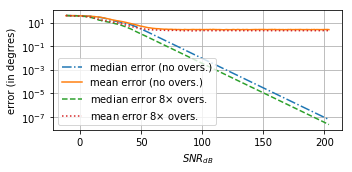

In [3]:
n_pow = np.concatenate([np.arange(-2.46, -1.05, 0.07037), np.linspace(-1, 9, 199)])
n_len = len(n_pow)

results = np.empty((2, 4, n_len))
all_errors = np.empty((4, n_len, 100*13))
all_power = np.empty((4, n_len, 100*13))
n = 5

for (overs, idx) in zip([1, 2, 4, 8], range(4)):
    for (nl, n_idx) in zip(n_pow, range(len(n_pow))):
        code = code = "{}_{}_{:.2f}".format(n, overs,nl)
        power = np.load('results/pow_' + code + '.npy')
        errors = np.load('results/errors_' + code + '.npy')
        errors[np.isnan(errors)]=1
        results[0, idx, n_idx] = np.degrees(np.percentile(errors, q=50))
        results[1, idx, n_idx] = np.degrees(np.mean(errors.flatten()))
        all_power[idx, n_idx,:] = power.flatten()
        all_errors[idx, n_idx,:] = errors.flatten()
        
snr = 10*(np.log(np.mean(all_power.flatten())) + 2 * n_pow)
beg = 10
fig = plt.figure()
plt.semilogy(snr[beg:], results[0,0,beg:].T, "-.")
plt.semilogy(snr[beg:], results[1,0,beg:].T)
plt.semilogy(snr[beg:], results[0,3,beg:].T, "--")
plt.semilogy(snr[beg:], results[1,3,beg:].T, ":")
plt.xlabel(r"$SNR_{dB}$")
plt.ylabel("error (in degrres)")
plt.legend([r"median error (no overs.)", r"mean error (no overs.)", r"median error 8$\times$ overs.", r"mean error 8$\times$ overs."], loc='best')
plt.grid()
plt.tight_layout()
plt.show()
fig.savefig('snr2.pdf')